In [4]:
import os, math
from collections import defaultdict, namedtuple, deque
import dataclasses
from dataclasses import dataclass
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [5]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()
    
print(f'xp = {xp.__name__}')

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name))
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name))

mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, fork method leads to failures in bootstrap somewhere around CUDA

xp = numpy


In [6]:
%run sequencing_sp2.ipynb

# Open DB

In [7]:
DF_TEST_RESULTS = pd.DataFrame(columns=['test_run_id', 'config_variant', 'cortical_columns', 'train_images_count', 'train_runs',
                                        'source_ds', 'test_image_id', 'true_value', 'infer_value', 'match_tab_index', 'match_score'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [8]:
hdc = Hdc(10_000, xp)

In [9]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.48 μs


((100, 9), (20, 9))


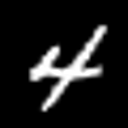
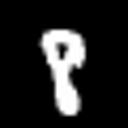
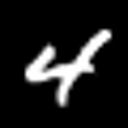
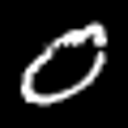
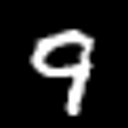
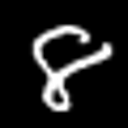
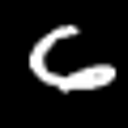
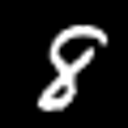
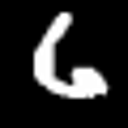
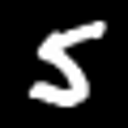
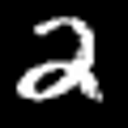
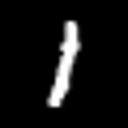
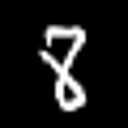
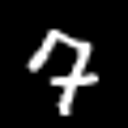
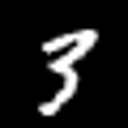
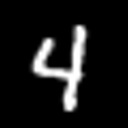

In [10]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

In [11]:
def render_image(image_id, df_images, image_sz=(600, 600)):
    df_image = df_images.loc[image_id]
    image_png = df_image['png']
    image = Image.open(io.BytesIO(image_png))
    image = image.convert('RGB')
    k = image.size[0]
    image = image.resize(image_sz)
    k = image.size[0] / k
    image_draw = ImageDraw.Draw(image)

    inner_si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    inner_sequences = pickle.loads(df_image['inner_sequences'])
        
    for seq in inner_sequences:
        for si_ind_from, si_ind_to in zip(seq, seq[1:]):
            si_from = inner_si_ind_dict[si_ind_from]
            si_to = inner_si_ind_dict[si_ind_to]
            pt_from = si_from.x * k, si_from.y * k
            pt_to = si_to.x * k, si_to.y * k
            image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')
            
            nl = 6 * k
            image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline='red')
            normal_vec = si_from.normal_vec
            image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_ind_from), anchor='mm', fill='red')

            image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline='red')
            normal_vec = si_to.normal_vec
            image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')

    return image

In [12]:
COS_SIM_45 = np.sqrt(2) / 2
COS_SIM_30 = np.sqrt(3) / 2

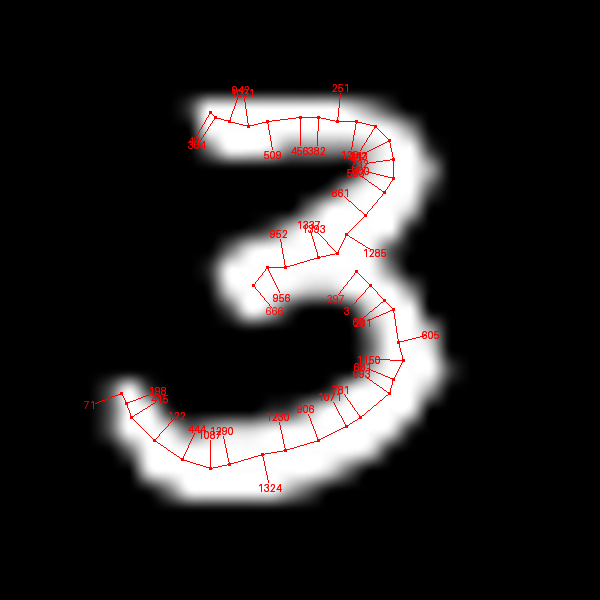

In [96]:
image_id = RNG.choice(df_train_images.index)
df_image = df_train_images.loc[image_id]
render_image(image_id, df_train_images)

In [97]:
Engram = namedtuple('Engram', ['s', 'x', 'y', 'n', 'max_std_sq'])

In [101]:
inner_si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
inner_sequences = pickle.loads(df_image['inner_sequences'])
inner_sequence = np.array(list(itertools.chain.from_iterable(inner_sequences)))
expand_normal_vec = lambda j: (j.real, j.imag)
inner_normal_sequence = np.array(list(map(lambda si_ind: expand_normal_vec(inner_si_ind_dict[si_ind].normal_vec), inner_sequence)))
inner_vec_sequence = pickle.loads(df_image['inner_vec_sequence'])
assert len(inner_vec_sequence) == len(inner_normal_sequence)

In [102]:
phased_sequences = []
phased_xy_sequences = []
phased_normal_sequences = []

for phase in range(inner_vec_sequence.shape[0]):
    phased_vec_sequence = np.roll(inner_vec_sequence, -phase, axis=0)
    xy_list = [(0, 0)]
        
    for vec in phased_vec_sequence[:-1]:
        xy_list.append((xy_list[-1][0] + vec[0], xy_list[-1][1] + vec[1]))

    phased_sequences.append(np.roll(inner_sequence, -phase, axis=0))
    phased_xy_sequences.append(np.array(xy_list))
    phased_normal_sequences.append(np.roll(inner_normal_sequence, -phase, axis=0))

phased_xy_sequences = np.array(phased_xy_sequences)
phased_normal_sequences = np.array(phased_normal_sequences)
phased_x_sequences = phased_xy_sequences[..., 0]
phased_y_sequences = phased_xy_sequences[..., 1]
max_std = max(np.std(phased_x_sequences[0]), np.std(phased_y_sequences[0]))
engram = Engram(s=phased_sequences, x=phased_x_sequences, y=phased_y_sequences, n=phased_normal_sequences, max_std_sq=max_std ** 2)

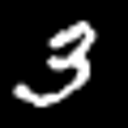

In [171]:
image_id2 = RNG.choice(df_train_images.index)
df_image2 = df_train_images.loc[image_id2]
Image.open(io.BytesIO(df_image2['png']))

In [172]:
image_id2

np.int64(5941)

In [173]:
image2_xy_seq = pickle.loads(df_image2['inner_xy_sequence'])
image2_x_seq = image2_xy_seq[:,0]
image2_y_seq = image2_xy_seq[:,1]
image2_x_sq_seq = image2_x_seq * image2_x_seq
image2_y_sq_seq = image2_y_seq * image2_y_seq

image2_inner_si_ind_dict = pickle.loads(df_image2['inner_si_ind_dict'])
image2_inner_sequences = pickle.loads(df_image2['inner_sequences'])
image2_inner_sequence = list(itertools.chain.from_iterable(image2_inner_sequences))
image2_n_seq = np.array(list(map(lambda si_ind: expand_normal_vec(image2_inner_si_ind_dict[si_ind].normal_vec), image2_inner_sequence)))

assert image2_n_seq.shape[0] == image2_x_seq.shape[0]
assert image2_n_seq.shape[0] == image2_y_seq.shape[0]

In [174]:
%%time
image2_pt_index = RNG.choice(image2_x_seq.shape[0])
image2_pt = (image2_pt_index, 0)

x1 = engram.x.copy()
x1 = x1.reshape(-1, 1)
x2 = image2_x_seq[:,np.newaxis]

x1 += x2[image2_pt]

#x1_sq = engram.x_sq.reshape(1, -1)
x1_sq = (x1 * x1).T
x1_sq = np.vstack([x1_sq, np.ones(x1_sq.shape[-1])])
x2_sq = np.vstack([np.ones(image2_x_sq_seq.shape[-1]), image2_x_sq_seq])
x1_sq_plus_x2_sq = x1_sq.T @ x2_sq
x1_times_x2 = x1 @ x2.T
x_dist_sq = x1_sq_plus_x2_sq - (2 * x1_times_x2)

# x_dist_sq2 = np.zeros((x1.shape[0], x2.shape[0]))

# for i in range(x1.shape[0]):
#     for j in range(x2.shape[0]):
#         x_dist_sq2[i,j] = (x1[i,0] - x2[j,0]) ** 2 

# assert np.array_equal(x_dist_sq, x_dist_sq2) 

x_dist_sq = x_dist_sq.reshape(engram.x.shape[0], engram.x.shape[0], image2_x_seq.shape[0])

y1 = engram.y.copy()
y1 = y1.reshape(-1, 1)
y2 = image2_y_seq[:,np.newaxis]

y1 += y2[image2_pt]

# y1_sq = engram.y_sq.reshape(1, -1)
y1_sq = (y1 * y1).T
y1_sq = np.vstack([y1_sq, np.ones(y1_sq.shape[-1])])
y2_sq = np.vstack([np.ones(image2_y_sq_seq.shape[-1]), image2_y_sq_seq])
y1_sq_plus_y2_sq = y1_sq.T @ y2_sq
y1_times_y2 = y1 @ y2.T
y_dist_sq = y1_sq_plus_y2_sq - (2 * y1_times_y2)

# y_dist_sq2 = np.zeros((y1.shape[0], y2.shape[0]))

# for i in range(y1.shape[0]):
#     for j in range(y2.shape[0]):
#         y_dist_sq2[i,j] = (y1[i,0] - y2[j,0]) ** 2 

# assert np.array_equal(y_dist_sq, y_dist_sq2) 

y_dist_sq = y_dist_sq.reshape(engram.y.shape[0], engram.y.shape[0], image2_y_seq.shape[0])

n1 = engram.n.reshape(-1, 2)
n2 = image2_n_seq.T
n1_dot_prod_n2 = np.abs(n1 @ n2)
n_dist_sq = np.where(n1_dot_prod_n2 < COS_SIM_45, engram.max_std_sq, 0)
n_dist_sq = n_dist_sq.reshape(engram.n.shape[0], engram.n.shape[0], image2_n_seq.shape[0])

dist_sq = x_dist_sq + y_dist_sq + n_dist_sq
# dist_sq = x_dist_sq + y_dist_sq
dist_sq.shape

CPU times: user 2.43 ms, sys: 0 ns, total: 2.43 ms
Wall time: 2.17 ms


(41, 41, 42)

In [175]:
assign_tabs = {} # key - phase_index, value - array (engram_si_index, image2_si_index, dist) = assign tab

for phase_index in range(dist_sq.shape[0]):
    dist_sq_for_phase = dist_sq[phase_index].copy()
    sort_indices = np.argsort(dist_sq_for_phase, axis=None)

    stride = dist_sq_for_phase.shape[1]
    assign_tab = []
    i_to_j_dict = {}
    j_to_i_dict = {}
    
    for flat_ij in sort_indices.ravel():
        i = flat_ij // stride
        j = flat_ij % stride
        d = dist_sq_for_phase[i,j]

        if d >= 0:
            if d < engram.max_std_sq:
                assign_tab.append((i, j, d))
                i_to_j_dict[i] = j
                j_to_i_dict[j] = i
                
            dist_sq_for_phase[i,:] = -1
            dist_sq_for_phase[:,j] = -1

    assign_tab = np.array(assign_tab, dtype='i8')
    assign_tab_mask = []

    phased_sequence = engram.s[phase_index]
    
    # Filter out from assign tab connections which do not belong to adjacent sis on both sides.
    # This way we can filter out unwanted crosses of connections. In other words we favor seq to seq matches
    for assign_tab_row in assign_tab:
        i = assign_tab_row[0]
        j = assign_tab_row[1]

        is_standalone = (not (i-1) in i_to_j_dict and not (i+1) in i_to_j_dict and not (j-1) in j_to_i_dict and not (j+1) in j_to_i_dict)
        is_prev_i_ok = i_to_j_dict.get(i-1, -999) in (j-1, j+1)
        is_next_i_ok = i_to_j_dict.get(i+1, -999) in (j-1, j+1)
        is_prev_j_ok = j_to_i_dict.get(j-1, -999) in (i-1, i+1)
        is_next_j_ok = j_to_i_dict.get(j+1, -999) in (i-1, i+1)

        assign_tab_mask.append(is_standalone or ((is_prev_i_ok or is_next_i_ok) and (is_prev_j_ok or is_next_j_ok)))
    
    assign_tabs[phase_index] = assign_tab[assign_tab_mask]

# assign_score_vecs = np.zeros((len(assign_tabs), 3))
assign_score_vecs = np.zeros((len(assign_tabs), 2))
# assign_integr_scores = np.zeros(len(assign_tabs))

for phase_index, assign_tab in assign_tabs.items():
    # assign_integr_scores[phase_index] = assign_tabs[phase_index][:,2].sum()
    dist_sq_sum = assign_tabs[phase_index][:,2].sum()
    unmatched_engram_sis = len(set(range(dist_sq.shape[0])) - set(assign_tab[:,0]))
    unmatched_image2_sis = len(set(range(dist_sq.shape[2])) - set(assign_tab[:,1]))
    # assign_score_vecs[phase_index] = (dist_sq_sum, unmatched_engram_sis ** 2, unmatched_image2_sis ** 2)
    assign_score_vecs[phase_index] = (unmatched_engram_sis, unmatched_image2_sis)

assign_integr_scores = np.sqrt(np.sum(assign_score_vecs ** 2, axis=1))
best_assign_integr_score = np.argmin(assign_integr_scores)

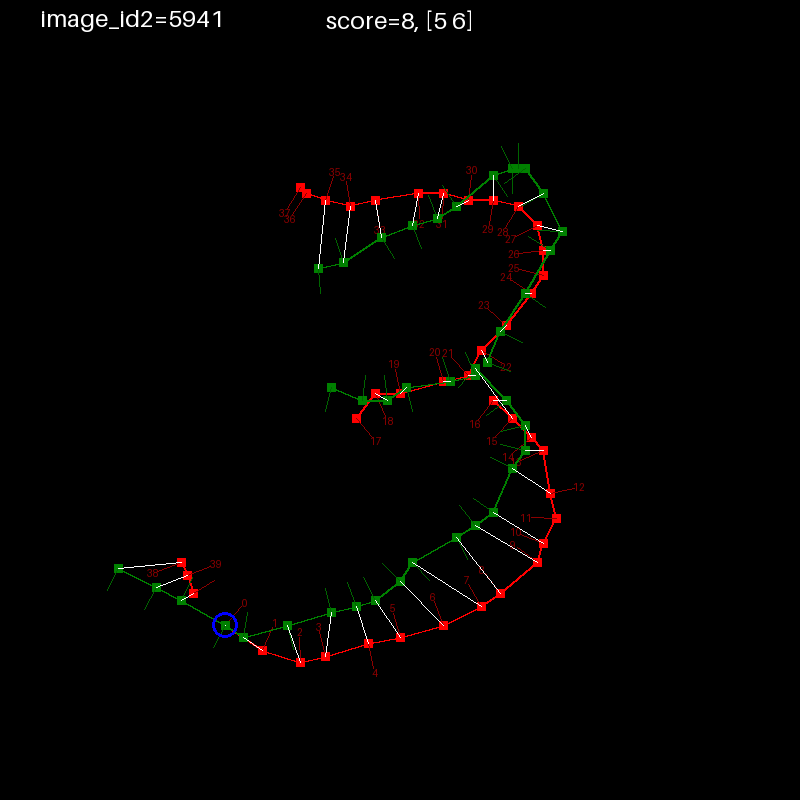

In [176]:
image_pil = Image.new('L', size=(800, 800), color='black')
image_pil = image_pil.convert('RGB')
k = image_pil.size[0] / config.sample_size
draw = ImageDraw.Draw(image_pil)

s = engram.s[best_assign_integr_score]
s = np.vstack([s, np.roll(s, -1, axis=0)]).T

xy_list = np.vstack([engram.x[best_assign_integr_score], engram.y[best_assign_integr_score]]).T
xy_list = xy_list.astype('f')

assert s.shape[0] == xy_list.shape[0]

image2_pt_xy = image2_xy_seq[image2_pt_index]
xy_list += image2_pt_xy
xy_list = np.hstack([xy_list, np.roll(xy_list, -1, axis=0)])

engram_si_serial_to_xy = {}

for si_serial, (xy_list_row, s_row) in enumerate(zip(xy_list[:-1], s[:-1])):
    pt_from = xy_list_row[0], xy_list_row[1]
    pt_to = xy_list_row[2], xy_list_row[3]
    
    vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]

    if np.linalg.norm(vec) < 10:
        draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='red')
        
    draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='red')
    draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='red')

    si_from = inner_si_ind_dict[s_row[0]]
    si_to = inner_si_ind_dict[s_row[1]]
    nl = 4 * k
    normal_vec = si_from.normal_vec
    draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
    draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')

    normal_vec = si_to.normal_vec
    draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
    # draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')
    
    engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
    engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])

image2_si_serial_to_xy = {}

for si_serial, (xy_list_row, s_row) in enumerate(zip(zip(image2_xy_seq, image2_xy_seq[1:]), zip(image2_inner_sequence, image2_inner_sequence[1:]))):
    pt_from = xy_list_row[0][0], xy_list_row[0][1] 
    pt_to = xy_list_row[1][0], xy_list_row[1][1]
    vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
    # color = 'red' if np.linalg.norm(vec) < 10 else 'gray'

    if np.linalg.norm(vec) < 10:
        draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='green')
        
    draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='green')
    draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='green')

    si_from = image2_inner_si_ind_dict[s_row[0]]
    si_to = image2_inner_si_ind_dict[s_row[1]]
    nl = 4 * k
    normal_vec = si_from.normal_vec
    draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
    # draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_ind_from), anchor='mm', fill='red')

    normal_vec = si_to.normal_vec
    draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
    # draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')
    
    image2_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
    image2_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])

assign_tab = assign_tabs[best_assign_integr_score]

for engram_si_serial, image_si_serial, dist in assign_tab:
    engram_si_ind_xy = engram_si_serial_to_xy[engram_si_serial]
    image2_si_xy = image2_si_serial_to_xy[image_si_serial]
    draw.line([engram_si_ind_xy[0], engram_si_ind_xy[1], image2_si_xy[0], image2_si_xy[1]], width=1, fill='white')

draw.circle((k * image2_pt_xy[0], k * image2_pt_xy[1]), radius=k*2, outline='blue', width=3)

# image_pil.resize((500, 500))
draw.text((image_pil.size[0] / 2, 10), f'score={assign_integr_scores[best_assign_integr_score]:.0f}, {assign_score_vecs[best_assign_integr_score].astype(int)}', font_size=24, anchor='mt')
draw.text((image_pil.size[0] / 6, 10), f'image_id2={image_id2}', font_size=24, anchor='mt')
image_pil

In [240]:
engram_si_ind

np.int64(6)

# Train

In [ ]:
assert False

In [51]:
%%time

train_runs = 1
count = min(1000, len(df_train_images))

for _ in tqdm(range(train_runs)):
    TRAIN_RUN_ID += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    # image_ids = [21514]
    # image_ids = [21613]
    # image_ids = image_ids[0:1]
    
    for image_id in image_ids:
        df_image = df_train_images.loc[image_id]
        image_value = df_image['value']
        sensor_instance_ind_dict = pickle.loads(df_image['si'])
        sequences_full = pickle.loads(df_image['seq'])
        sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
        sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
        connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
        assert len(connection_vectors_list) == len(sequences)
        match_tab = get_match_tab(sequences, sensor_instance_ind_dict, sensor_instance_ind_to_latent_vector, connection_vectors_list)
        best_match_index = np.argmin(match_tab['match_score']) if match_tab['match_score'] else -1

        if best_match_index >= 0 and np.isfinite(match_tab['match_score'][best_match_index]) and match_tab['candidate_value'][best_match_index] == image_value:
            continue

        engram = Engram(next(ENGRAM_ID_SOURCE), image_id, str(df_image['value']), len(sequences), [])
        ENGRAM_DICT[engram.engram_id] = engram

        for seq_index, (seq, connection_vectors)  in enumerate(zip(sequences, connection_vectors_list)):
            seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
                
            for i, si_ind in enumerate(seq):
                rolled_seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind])
                seq_lv_boxed = SeqLatentVec(engram.engram_id, seq_index, si_ind, rolled_seq_lv)
                engram.seq_lvs.append(seq_lv_boxed)

                lv = sensor_instance_ind_to_latent_vector[si_ind]
                latent_vector_i = HOOK_LVS.lease()
                HOOK_LVS.array_active[latent_vector_i] = lv
                
                SEQ_LV_DICT[latent_vector_i] = seq_lv_boxed

        print(f'New engram for {image_id:5} {image_value}')

    print(f'Total engrams {len(ENGRAM_DICT)}')

  0%|          | 0/1 [00:00<?, ?it/s]

New engram for 58445 8
New engram for  8619 8
New engram for 23580 4
New engram for 27684 1
New engram for 18034 6
New engram for 16887 1
New engram for 30907 3
New engram for 52637 2
New engram for  2061 6
New engram for 37814 0
New engram for  5269 7
New engram for 42444 0
New engram for 11087 8
New engram for 45615 7
New engram for 32203 3
New engram for  8604 7
New engram for 37725 1
New engram for 18579 9
New engram for  5937 9
New engram for 43605 6
New engram for 53928 0
New engram for  2547 1
New engram for  2840 2
New engram for 24327 4
New engram for 32902 5
New engram for 38696 0
New engram for  6845 7
New engram for  3691 0
New engram for 59194 9
New engram for 28199 3
New engram for 33097 8
New engram for 39398 2
New engram for 34053 1
New engram for 57258 9
New engram for 34103 9
New engram for 53687 1
New engram for 56110 1
New engram for 33647 0
New engram for  8523 6
New engram for 41080 2
New engram for 46687 2
New engram for 19101 3
New engram for 18003 2
New engram 

In [52]:
%%time
TEST_RUN_ID += 1
test_run_source = (df_test_images, test_db_con, 'test')
# test_run_source = (df_train_images, train_db_con, 'train')
count = min(200, len(test_run_source[0]))
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
# test_image_ids = [100006748]
# test_image_ids = image_ids
test_result_rows = defaultdict(list)
match_tabs = []

for image_id in tqdm(test_image_ids):
    df_image = test_run_source[0].loc[image_id]
    image_value = df_image['value']
    sensor_instance_ind_dict = pickle.loads(df_image['si'])
    sequences_full = pickle.loads(df_image['seq'])
    sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)    
    sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
    connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
    # seq_lvs = []
    
    # for seq, connection_vectors in zip(sequences, connection_vectors_list):
    #     seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
    #     seq_lvs.append((seq_lv, si_ind_to_offset))

    # engram_to_match_mat = {}
    
    # # Check every sequence of an image under study
    # for seq_index, seq in enumerate(sequences):
    #     seq_lv, si_ind_to_offset = seq_lvs[seq_index]
    #     # seq_lv_phases = np.empty((seq_lv.shape[0], seq_lv.shape[0]), dtype='F')

    #     # for i in range(seq_lv.shape[0]):
    #     #     seq_lv_phases[i] = seq_lv
    #     #     seq_lv = np.roll(seq_lv, +1)
        
    #     for si_ind in seq:
    #         si_lv = sensor_instance_ind_to_latent_vector[si_ind]
    #         seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind]) # phasing
    #         cos_sims = HOOK_LVS.array_active @ si_lv
    #         cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
            
    #         for cos_sim_index in cos_sim_indices:
    #             candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
    #             candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]
            
    #             if not candidate_engram.engram_id in engram_to_match_mat:
    #                 engram_to_match_mat[candidate_engram.engram_id] = np.full((candidate_engram.seqs_count, len(sequences)), np.inf)
                    
    #             match_mat = engram_to_match_mat[candidate_engram.engram_id]
    #             match_mat_score = match_mat[candidate_seq_lv_box.seq_index, seq_index]
                
    #             seq_lv_diff = candidate_seq_lv_box.lv - seq_lv
    #             score = np.sum(np.absolute(seq_lv_diff))
    
    #             if score < match_mat_score:
    #                 match_mat[candidate_seq_lv_box.seq_index, seq_index] = score

    #             ##################
    #             # if np.isfinite(match_mat[candidate_seq_lv_box.seq_index,seq_index]):
    #             #     # this relation (candidate_seq_lv_box.seq_index VS seq_index) is already assessed
    #             #     continue
        
    #             # # Find best match between seq_lv and candidate_seq_lv_box.lv via thorough phasing
    #             # seq_lv_diffs_mat = candidate_seq_lv_box.lv - seq_lv_phases
    #             # seq_lv_diffs_mat = np.absolute(seq_lv_diffs_mat)
    #             # seq_lv_diffs_vec = np.sum(seq_lv_diffs_mat, axis=1)
    #             # match_mat[candidate_seq_lv_box.seq_index, seq_index] = np.min(seq_lv_diffs_vec)
    
    # match_tab = defaultdict(list)
    
    # for engram_id, match_mat in engram_to_match_mat.items():
    #     # Reduce match matrix to vector of least error scores for each column (each sequence of image under study)
    #     match_vector = np.full(len(sequences), np.inf)
    #     assert len(sequences) == match_mat.shape[1]
    #     match_mat_work = match_mat.copy()
        
    #     for j in range(match_mat_work.shape[1]):
    #         i = np.argmin(match_mat_work[:,j])
    #         match_vector[j] = match_mat_work[i,j]
    #         match_mat_work[:,j] = np.inf
    #         match_mat_work[i,:] = np.inf

    #     if not np.all(np.isfinite(np.min(match_mat, axis=1))):
    #         match_score = np.inf
    #     else:
    #         match_score = np.sum(match_vector)

    #     candidate_engram = ENGRAM_DICT[engram_id]
    #     match_tab['image_id'] = image_id
    #     match_tab['value'] = image_value
    #     match_tab['candidate_engram_id'].append(engram_id)
    #     match_tab['candidate_image_id'].append(candidate_engram.image_id)
    #     match_tab['candidate_value'].append(candidate_engram.value)
    #     match_tab['match_mat'].append(match_mat)
    #     match_tab['match_vector'].append(match_vector)
    #     match_tab['match_score'].append(match_score)

    match_tab = get_match_tab(sequences, sensor_instance_ind_dict, sensor_instance_ind_to_latent_vector, connection_vectors_list)
    df_match_tab = pd.DataFrame(match_tab)
    df_match_tab.sort_values(by=['match_score'], inplace=True)
    match_tabs.append(df_match_tab)

    if len(df_match_tab) > 0 and np.isfinite(df_match_tab.iloc[0].match_score):
        infer_value = df_match_tab.iloc[0]['candidate_value']
    else:
        infer_value = ''
    
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append([])
    test_result_rows['train_images_count'].append(len(ENGRAM_DICT))
    test_result_rows['train_runs'].append(TRAIN_RUN_ID)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['infer_value'].append(infer_value)
    test_result_rows['match_score'].append(df_match_tab.iloc[0]['match_score'])
    test_result_rows['match_tab_index'].append(len(match_tabs) - 1)
    

assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns), set(test_result_rows.keys()) ^ set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 14.8 s, sys: 45 ms, total: 14.9 s
Wall time: 14.8 s


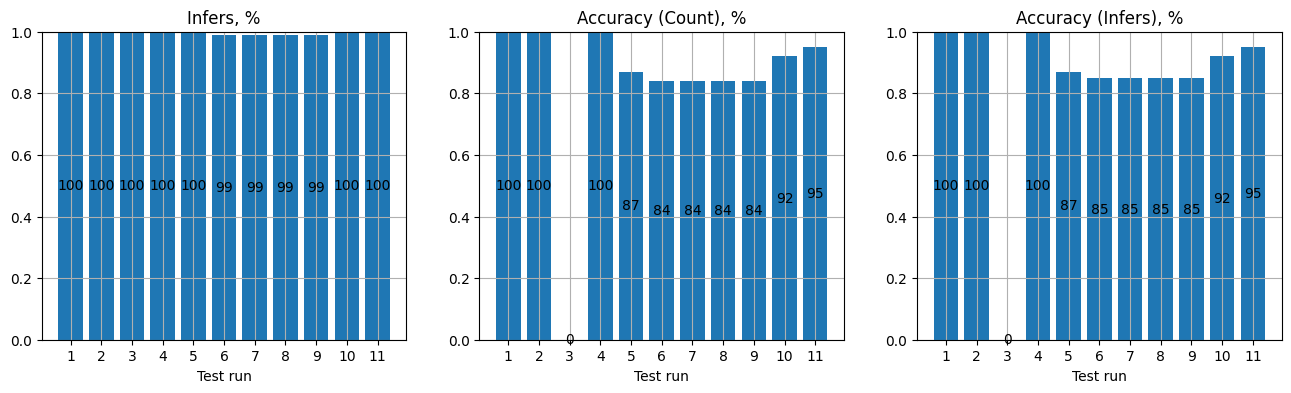

,config_variant,source_ds,cortical_columns,train_images_count,train_runs,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,,
1,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,1,1,1,1.00,1.00,1.000000
2,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,1,1,1,1.00,1.00,1.000000
3,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,1,1,0,1.00,0.00,0.000000
4,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,1,1,1,1.00,1.00,1.000000
5,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,100,100,87,1.00,0.87,0.870000
6,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,200,198,168,0.99,0.84,0.848485
7,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,200,198,168,0.99,0.84,0.848485
8,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,200,198,168,0.99,0.84,0.848485
9,SQLITE3_SEQ_GRID_0_4096,test,[],100,1,200,198,168,0.99,0.84,0.848485


In [53]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [54]:
df_last_run_results = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == max(DF_TEST_RESULTS.test_run_id)]
df_incorrect = df_last_run_results.loc[df_last_run_results.true_value != df_last_run_results.infer_value]
df_incorrect

,test_run_id,config_variant,cortical_columns,train_images_count,train_runs,source_ds,test_image_id,true_value,infer_value,match_tab_index,match_score
1129,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100008106,7,1,25,294.156799
1185,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100000257,8,0,81,889.921692
1224,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100001440,4,8,120,446.201813
1237,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100001529,4,9,133,393.627350
1249,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100007388,5,3,145,512.188782
1252,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100001823,8,4,148,715.773499
1254,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100002454,6,0,150,669.098633
1262,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100008984,7,4,158,1133.187134
1280,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100000583,2,0,176,984.615417
1289,11,SQLITE3_SEQ_GRID_0_4096,[],204,13,test,100004048,0,7,185,368.627930


In [123]:
df_last_run_results = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == max(DF_TEST_RESULTS.test_run_id)]
df_correct = df_last_run_results.loc[df_last_run_results.true_value == df_last_run_results.infer_value]
# list(df_correct.match_tab_index)

In [74]:
df_last_run_results.loc[df_last_run_results.true_value == df_last_run_results.infer_value].match_score.describe()

count     190.000000
mean      589.994401
std       276.728774
min       114.231644
25%       411.731316
50%       541.339111
75%       724.504585
max      2093.085632
Name: match_score, dtype: float64

In [75]:
df_last_run_results.loc[(df_last_run_results.true_value != df_last_run_results.infer_value) & (np.isfinite(df_last_run_results.match_score))].match_score.describe()

count      10.000000
mean      640.739905
std       286.527159
min       294.156799
25%       406.770966
50%       590.643707
75%       846.384644
max      1133.187134
Name: match_score, dtype: float64

In [125]:
match_tabs[145]

,image_id,value,candidate_engram_id,candidate_image_id,candidate_value,match_mat,match_vector,match_score
166,100007388,5,199,40480,3,[[512.1887817382812]],[512.1887817382812],512.188782
1,100007388,5,2,33537,5,[[517.3086547851562]],[517.3086547851562],517.308655
102,100007388,5,119,28679,5,[[534.7312622070312]],[534.7312622070312],534.731262
65,100007388,5,76,5526,5,[[598.6135864257812]],[598.6135864257812],598.613586
134,100007388,5,156,32902,5,[[610.102783203125]],[610.102783203125],610.102783
...,...,...,...,...,...,...,...,...
171,100007388,5,204,22139,2,"[[924.259765625], [inf]]",[924.259765625],inf
169,100007388,5,202,47558,4,"[[890.302001953125], [inf]]",[890.302001953125],inf
160,100007388,5,193,31039,8,"[[950.9163818359375], [inf]]",[950.9163818359375],inf
162,100007388,5,195,52092,7,"[[1046.639892578125], [inf]]",[1046.639892578125],inf


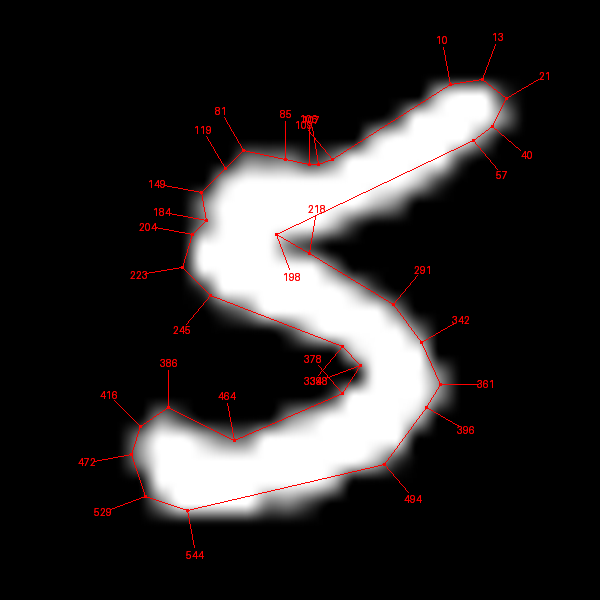

In [126]:
render_image(100007388, df_test_images, with_sequences=True)

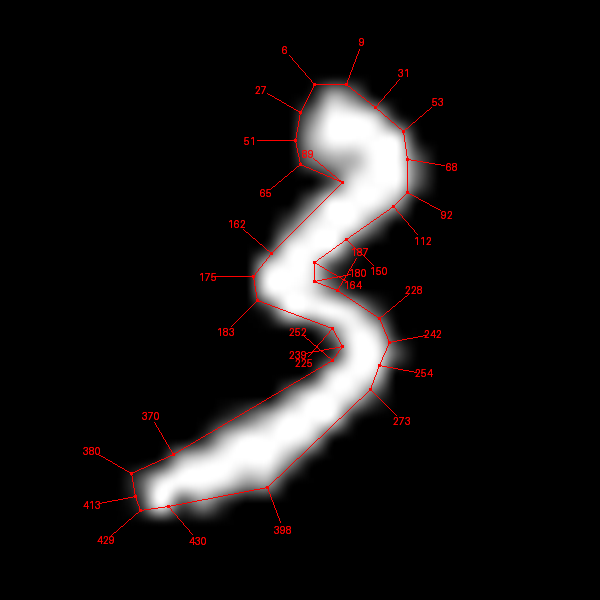

In [127]:
render_image(40480, df_train_images, with_sequences=True)

In [128]:
df_image = test_run_source[0].loc[100007388]
sensor_instance_ind_dict = pickle.loads(df_image['si'])
sequences_full = pickle.loads(df_image['seq'])
sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
seq_lvs = []

for seq, connection_vectors in zip(sequences, connection_vectors_list):
    seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
    seq_lvs.append((seq_lv, si_ind_to_offset))

engram_to_match_mat = {}

# Check every sequence of an image under study
for seq_index, seq in enumerate(sequences):
    # seq_lv, si_ind_to_offset = seq_lvs[seq_index]
    seq_lv, _ = seq_lvs[seq_index]
    seq_lv_phases = np.empty((seq_lv.shape[0], seq_lv.shape[0]), dtype='F')

    for i in range(seq_lv.shape[0]):
        seq_lv_phases[i] = seq_lv
        seq_lv = np.roll(seq_lv, +1)
    
    # Explore various hooks - one may be better than other due to different phases of rolled seq_lv
    si_inds = RNG.choice(seq, min(5, len(seq)), replace=False)

    for si_ind in si_inds:
        si_lv = sensor_instance_ind_to_latent_vector[si_ind]
        cos_sims = HOOK_LVS.array_active @ si_lv
        cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
        
        for cos_sim_index in cos_sim_indices:
            candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
            candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]

            if candidate_engram.image_id != 40480:
                continue
        
            if not candidate_engram.engram_id in engram_to_match_mat:
                engram_to_match_mat[candidate_engram.engram_id] = np.full((candidate_engram.seqs_count, len(sequences)), np.inf)
                
            match_mat = engram_to_match_mat[candidate_engram.engram_id]
    
            if np.isfinite(match_mat[candidate_seq_lv_box.seq_index,seq_index]):
                # this relation (candidate_seq_lv_box.seq_index VS seq_index) is already assessed
                continue

            # print(candidate_seq_lv_box.seq_index, seq_index, candidate_seq_lv_box.lv[0])
            # Find best match between seq_lv and candidate_seq_lv_box.lv via thorough phasing
            seq_lv_diffs_mat = candidate_seq_lv_box.lv - seq_lv_phases
            seq_lv_diffs_mat = np.absolute(seq_lv_diffs_mat)
            seq_lv_diffs_vec = np.sum(seq_lv_diffs_mat, axis=1)
            match_mat[candidate_seq_lv_box.seq_index, seq_index] = np.min(seq_lv_diffs_vec)
            assert False

AssertionError: 

In [129]:
qqq = np.argmin(seq_lv_diffs_vec)

In [130]:
seq_lv_diffs_vec[qqq]

np.float32(505.31198)

In [131]:
np.absolute(candidate_seq_lv_box.lv - seq_lv_phases[qqq]).sum()

np.float32(505.31198)

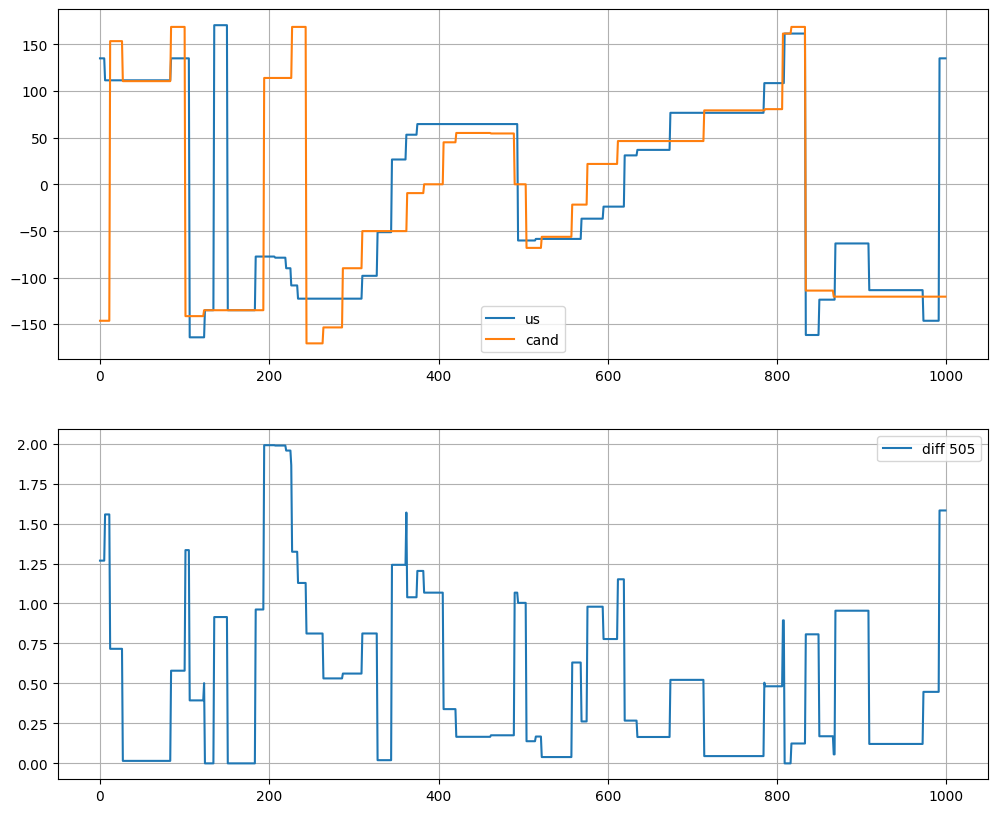

In [135]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(np.angle(seq_lv_phases[qqq], deg=True), label=f'us')
plt.plot(np.angle(candidate_seq_lv_box.lv, deg=True), label=f'cand')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.absolute(candidate_seq_lv_box.lv - seq_lv_phases[qqq]), label=f'diff {np.sum(np.absolute(candidate_seq_lv_box.lv - seq_lv_phases[qqq])):.0f}')
plt.grid()
plt.legend()

plt.show()

In [138]:
np.absolute(candidate_seq_lv_box.lv[200] - seq_lv_phases[qqq][200])

np.float32(1.9900527)

In [142]:
candidate_seq_lv_box.lv[200], seq_lv_phases[qqq][200], np.angle(candidate_seq_lv_box.lv[200], deg=True), np.angle(seq_lv_phases[qqq][200], deg=True)

(np.complex64(-0.40613848+0.91381156j),
 np.complex64(0.21693046-0.97618705j),
 np.float32(113.96249),
 np.float32(-77.47119))

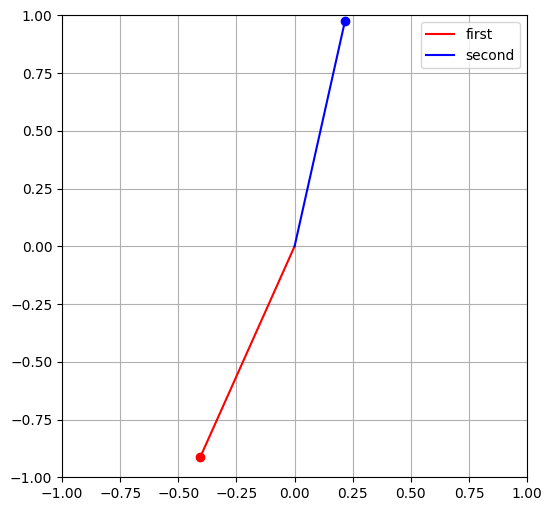

In [141]:
vec1 = [-0.40613848, +0.91381156,  0.21693046, -0.97618705]

plt.figure(figsize=(6, 6))
plt.plot([0, vec1[0]], [0, -vec1[1]], 'r', label='first')
plt.scatter(vec1[0], -vec1[1], c='r')
plt.plot([0, vec1[2]], [0, -vec1[3]], 'b', label='second')
plt.scatter(vec1[2], -vec1[3], c='b')
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.legend()
plt.grid()
plt.show()